# Analysis of the risk of failure of the O-rings on the Challenger shuttle

On January 27, 1986, the day before the takeoff of the shuttle _Challenger_, had
a three-hour teleconference was held between 
Morton Thiokol (the manufacturer of one of the engines) and NASA. The
discussion focused on the consequences of the
temperature at take-off of 31°F (just below
0°C) for the success of the flight and in particular on the performance of the
O-rings used in the engines. Indeed, no test
had been performed at this temperature.

The following study takes up some of the analyses carried out that
night with the objective of assessing the potential influence of
the temperature and pressure to which the O-rings are subjected
on their probability of malfunction. Our starting point is 
the results of the experiments carried out by NASA engineers
during the six years preceding the launch of the shuttle
Challenger.

## Loading the data
We start by loading this data:

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv("shuttle.csv")
data

,Date,Count,Temperature,Pressure,Malfunction
0,4/12/81,6,66,50,0
1,11/12/81,6,70,50,1
2,3/22/82,6,69,50,0
3,11/11/82,6,68,50,0
4,4/04/83,6,67,50,0
5,6/18/82,6,72,50,0
6,8/30/83,6,73,100,0
7,11/28/83,6,70,100,0
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1


The data set shows us the date of each test, the number of O-rings (there are 6 on the main launcher), the temperature (in Fahrenheit) and pressure (in psi), and finally the number of identified malfunctions.

## Graphical inspection
Flights without incidents do not provide any information
on the influence of temperature or pressure on malfunction.
We thus focus on the experiments in which at least one O-ring
was defective.

In [2]:
data = data[data.Malfunction>0]
data

,Date,Count,Temperature,Pressure,Malfunction
1,11/12/81,6,70,50,1
8,2/03/84,6,57,200,1
9,4/06/84,6,63,200,1
10,8/30/84,6,70,200,1
13,1/24/85,6,53,200,2
20,10/30/85,6,75,200,2
22,1/12/86,6,58,200,1


We have a high temperature variability but
the pressure is almost always 200, which should
simplify the analysis.

How does the frequency of failure vary with temperature?

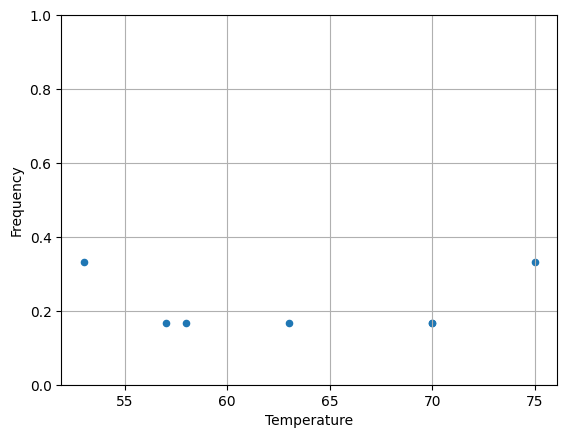

In [3]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

data["Frequency"]=data.Malfunction/data.Count
data.plot(x="Temperature",y="Frequency",kind="scatter",ylim=[0,1])
plt.grid(True)

At first glance, the dependence does not look very important, but let's try to
estimate the impact of temperature $t$ on the probability of O-ring malfunction.

## Estimation of the temperature influence

Suppose that each of the six O-rings is damaged with the same
probability and independently of the others and that this probability
depends only on the temperature. If $p(t)$ is this probability, the
number $D$ of malfunctioning O-rings during a flight at
temperature $t$ follows a binomial law with parameters $n=6$ and
$p=p(t)$. To link $p(t)$ to $t$, we will therefore perform a
logistic regression.

In [9]:
import statsmodels.api as sm

data["Success"]=data.Count-data.Malfunction
data["Intercept"]=1

logmodel=sm.GLM(data['Frequency'], data[['Intercept','Temperature']], family=sm.families.Binomial(sm.families.links.Logit())).fit()

logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Frequency   No. Observations:                    7
Model:                            GLM   Df Residuals:                        5
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2.5250
Date:                Sun, 08 Feb 2026   Deviance:                      0.22231
Time:                        17:11:54   Pearson chi2:                    0.236
No. Iterations:                     4   Pseudo R-squ. (CS):          1.926e-05
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.3895      7.828     -0.178      0.859     -16.732      13.953
Temperature     0.0014      0.122      0.012      0.991      -0.238       0.240
===============================================================================
"""

The most likely estimator of the temperature parameter is 0.0014
and the standard error of this estimator is 0.122, in other words we
cannot distinguish any particular impact and we must take our
estimates with caution.

## Estimation of the probability of O-ring malfunction

The expected temperature on the take-off day is 31°F. Let's try to
estimate the probability of O-ring malfunction at
this temperature from the model we just built:

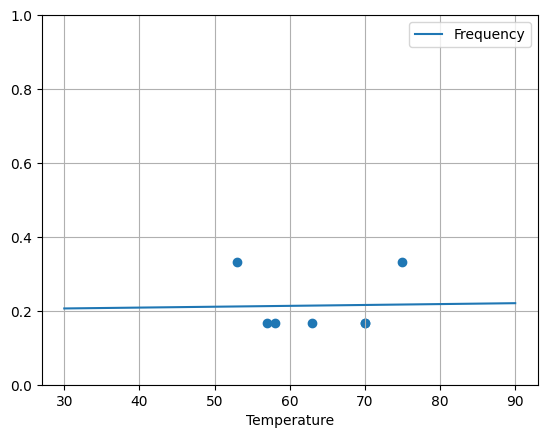

In [10]:
%matplotlib inline
data_pred = pd.DataFrame({'Temperature': np.linspace(start=30, stop=90, num=121), 'Intercept': 1})
data_pred['Frequency'] = logmodel.predict(data_pred[['Intercept','Temperature']])
data_pred.plot(x="Temperature",y="Frequency",kind="line",ylim=[0,1])
plt.scatter(x=data["Temperature"],y=data["Frequency"])
plt.grid(True)

As expected from the initial data, the
temperature has no significant impact on the probability of failure of the
O-rings. It will be about 0.2, as in the tests
where we had a failure of at least one joint. Let's get back
to the initial dataset to estimate the probability of failure:

In [11]:
data = pd.read_csv("shuttle.csv")
print(np.sum(data.Malfunction)/np.sum(data.Count))

0.06521739130434782


This probability is thus about $p=0.065$. Knowing that there is
a primary and a secondary O-ring on each of the three parts of the
launcher, the probability of failure of both joints of a launcher
is $p^2 \approx 0.00425$. The probability of failure of any one of the
launchers is $1-(1-p^2)^3 \approx 1.2%$.  That would really be
bad luck.... Everything is under control, so the takeoff can happen
tomorrow as planned.

But the next day, the Challenger shuttle exploded and took away
with her the seven crew members. The public was shocked and in
the subsequent investigation, the reliability of the
O-rings was questioned. Beyond the internal communication problems
of NASA, which have a lot to do with this fiasco, the previous analysis
includes (at least) a small problem.... Can you find it?
You are free to modify this analysis and to look at this dataset
from all angles in order to to explain what's wrong.

# Corrected analysis
Unlike the original analysis, we keep all flights, including those with 0 malfunction, because they are essential to estimate the real risk

In [7]:
import numpy as np
import pandas as pd

df = pd.read_csv("shuttle.csv")

In [8]:
df["Damage"] = (df["Malfunction"] > 0).astype(int)
df["Intercept"] = 1
df["Frequency"] = df["Malfunction"] / df["Count"]

print(df[["Temperature","Pressure","Malfunction","Damage","Frequency"]].head())

   Temperature  Pressure  Malfunction  Damage  Frequency
0           66        50            0       0   0.000000
1           70        50            1       1   0.166667
2           69        50            0       0   0.000000
3           68        50            0       0   0.000000
4           67        50            0       0   0.000000


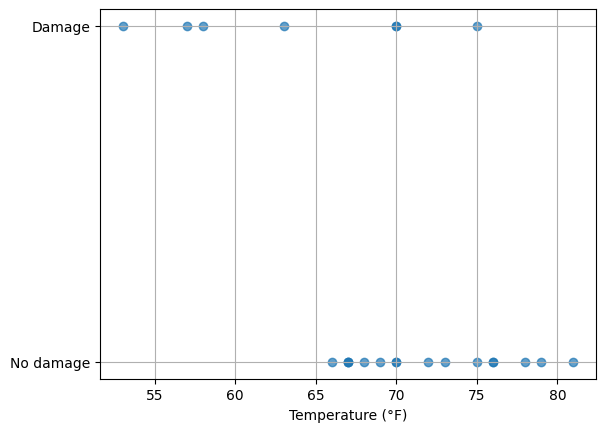

In [10]:
%matplotlib inline
pd.set_option('mode.chained_assignment',None) # this removes a useless warning from pandas
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df["Temperature"], df["Damage"], alpha=0.7)
plt.yticks([0,1], ["No damage", "Damage"])
plt.xlabel("Temperature (°F)")
plt.grid(True)
plt.show()

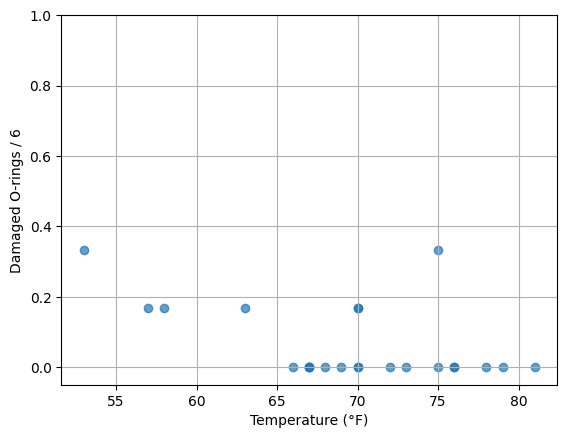

In [11]:
plt.figure()
plt.scatter(df["Temperature"], df["Frequency"], alpha=0.7)
plt.xlabel("Temperature (°F)")
plt.ylabel("Damaged O-rings / 6")
plt.ylim([-0.05, 1.0])
plt.grid(True)
plt.show()

This plot uses the full dataset (including damaged flights), so we can observe both no-damage and damage intensity.
The points at 0 dominate at higher temperatures, indicating lower damage frequency when warm.

### Logit Regression Model : 
We model the probability of at least one damaged O-ring as a function of temperature. This answers the real question: **P(damage | temperature)**.

In [13]:
import statsmodels.api as sm

X = df[["Intercept", "Temperature"]]
y = df["Damage"]

model = sm.Logit(y, X).fit(disp=False)
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                 Damage   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 08 Feb 2026   Pseudo R-squ.:                  0.2813
Time:                        17:46:19   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0429      7.379      2.039      0.041       0.581      29.505
Temperature    -0.2322      0.108     -2.145      0.032      -0.444      -0.020


- The temperature coefficient is negative (–0.232), meaning risk increases when temperature decreases.
- The effect is statistically significant (p = 0.032), so temperature is an important predictor.
- Overall model significance is strong (LLR p-value = 0.0048).

### Prediction at 31°F :

In [14]:
p31 = model.predict(
    pd.DataFrame({"Intercept": [1], "Temperature": [31]})
).iloc[0]

print("Predicted P(damage at 31°F) =", p31)

Predicted P(damage at 31°F) = 0.9996087828849319


The model predicts a very high probability of damage at 31°F (~0.9996). 
However, 31°F is outside the observed temperature range, so this is extrapolation; uncertainty is high, but the trend clearly indicates much higher risk in the cold.

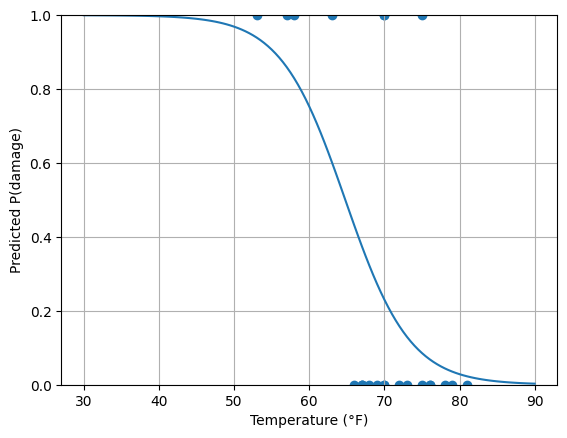

In [20]:
temps = np.linspace(30, 90, 121)
X_pred = pd.DataFrame({"Intercept": 1, "Temperature": temps})
p = model.predict(X_pred)

plt.figure()
plt.plot(temps, p)
plt.scatter(df["Temperature"], df["Damage"])
plt.xlabel("Temperature (°F)")
plt.ylabel("Predicted P(damage)")
plt.ylim([0, 1])
plt.grid(True)
plt.show()

* The fitted curve shows a steep increase in predicted risk as temperature drops.
* Most ‘no damage’ observations occur at higher temperatures, consistent with the model.

### Calculate uncertainty with confidence interval
Because 31°F lies outside the observed range, we quantify uncertainty.

In [21]:
beta = model.params.values
cov = model.cov_params().values

rng = np.random.default_rng(0)
B = 20000
beta_sim = rng.multivariate_normal(beta, cov, size=B)

def logistic(z): 
    return 1/(1+np.exp(-z))

z31 = beta_sim[:,0] + beta_sim[:,1]*31
p31_sim = logistic(z31)

ci_low, ci_high = np.quantile(p31_sim, [0.025, 0.975])
print(f"Approx 95% CI for P(damage at 31°F): [{ci_low:.3f}, {ci_high:.3f}]")

Approx 95% CI for P(damage at 31°F): [0.478, 1.000]


The predicted probability at 31°F has a wide 95% CI (0.499 to 1.000) : Even under uncertainty, the risk is still not small.

### Fit the Binomial GLM on counts

In [17]:
df["Success"] = df["Count"] - df["Malfunction"]
endog = np.column_stack([df["Malfunction"], df["Success"]])

logmodel = sm.GLM(endog, X, family=sm.families.Binomial()).fit()
print(logmodel.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   23
Model:                            GLM   Df Residuals:                       21
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15.823
Date:                Sun, 08 Feb 2026   Deviance:                       18.086
Time:                        17:46:51   Pearson chi2:                     30.0
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2344
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.0850      3.052      1.666      

The temperature coefficient is negative (−0.1156), meaning colder temperatures increase the per-O-ring damage probability.

In [19]:
# Predict expected damaged fraction at 31°F using the binomial GLM
p31_binom = logmodel.predict(
    pd.DataFrame({"Intercept": [1], "Temperature": [31]})
).iloc[0]

print("Predicted expected damaged fraction per O-ring at 31°F =", p31_binom)
print("Expected number of damaged O-rings (out of 6) at 31°F =", 6 * p31_binom)

Predicted expected damaged fraction per O-ring at 31°F = 0.8177744062821898
Expected number of damaged O-rings (out of 6) at 31°F = 4.906646437693139


Prediction at 31°F gives p ≈ 0.818 per O-ring (≈ 4.9/6 expected damaged), but this is extrapolation beyond observed temperatures.

### Conclusion : 
The original analysis was biased by removing zero-damage flights. Including all flights shows a clear temperature effect: colder launches have a higher probability of O-ring damage. The exact probability at 31°F is uncertain due to extrapolation, but the trend strongly indicates increased risk in cold conditions.